<a href="https://colab.research.google.com/github/melihkurtaran/Fraud_Detection/blob/main/FraudDetection_Generated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Fraud Detection Project**

In [1]:
#Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import KFold, StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools
from imblearn.over_sampling import SMOTE
from keras.models import Sequential
from keras.layers import Dense
import xgboost as xgb

In [2]:
#Connect to GitHub for faster access
!git clone https://github.com/melihkurtaran/Fraud_Detection.git

Cloning into 'Fraud_Detection'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 91 (delta 9), reused 0 (delta 0), pack-reused 70
Unpacking objects: 100% (91/91), 112.29 MiB | 3.17 MiB/s, done.
Updating files: 100% (27/27), done.


In [3]:
# Upload the gendered datasets
female = pd.read_csv("Fraud_Detection/datasets/generated_datasets/adults_2550_female_urban.csv", delimiter='|')
male = pd.read_csv("Fraud_Detection/datasets/generated_datasets/adults_2550_male_urban.csv", delimiter='|')

In [4]:
female = female.rename(columns={'merch_long,,': 'merch_long'})

# Merge the dataframes
df = pd.concat([female, male])

df = df.reset_index(drop=True)

In [5]:
df = df.drop(['merch_long'], axis=1)
df = df.drop(['lat','long','zip','merch_lat'], axis=1)

In [6]:
# Check for null values
null_df = df.isnull()

# Check if there are any null values in the original dataframe
if null_df.any().any():
    print("There are null values in the dataframe")
else:
    print("There are no null values in the dataframe")

There are no null values in the dataframe


In [8]:
df

,ssn,cc_num,first,last,gender,street,city,state,city_pop,job,...,acct_num,profile,trans_num,trans_date,trans_time,unix_time,category,amt,is_fraud,merchant
0,115-04-4507,4218196001337,Kathy,Johnson,F,863 Lawrence Valleys,Homosassa,FL,27123,Accounting technician,...,888022315787,adults_2550_female_urban.json,59f060ee29e40979a362acdb04315f6e,2022-12-12,01:47:59,1670806079,shopping_net,10.13,1,fraud_Fisher-Schowalter
1,115-04-4507,4218196001337,Kathy,Johnson,F,863 Lawrence Valleys,Homosassa,FL,27123,Accounting technician,...,888022315787,adults_2550_female_urban.json,faec1d6969fc4ed9b5182be0d4a0f15b,2022-12-12,03:39:36,1670812776,shopping_pos,814.04,1,fraud_Lynch Ltd
2,115-04-4507,4218196001337,Kathy,Johnson,F,863 Lawrence Valleys,Homosassa,FL,27123,Accounting technician,...,888022315787,adults_2550_female_urban.json,53fa6924f0c85c2a9eeee8e5a1f604fd,2022-12-12,02:33:53,1670808833,gas_transport,969.16,1,fraud_Cummerata-Jones
3,115-04-4507,4218196001337,Kathy,Johnson,F,863 Lawrence Valleys,Homosassa,FL,27123,Accounting technician,...,888022315787,adults_2550_female_urban.json,9869951e93f3dcf1ce8f8a1677741c3e,2022-12-13,03:36:20,1670898980,shopping_pos,743.97,1,fraud_Dooley Inc
4,115-04-4507,4218196001337,Kathy,Johnson,F,863 Lawrence Valleys,Homosassa,FL,27123,Accounting technician,...,888022315787,adults_2550_female_urban.json,6e037c9b466baf60e97b7eb63bfe6e49,2022-12-13,01:04:54,1670889894,shopping_pos,791.05,1,fraud_Stoltenberg-Beatty
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111959,521-67-0496,347507819735446,Thomas,Howard,M,777 King Tunnel Suite 964,Turlock,CA,77377,Theatre manager,...,35413216676,adults_2550_male_urban.json,74c50c93ba6df3b74e0290102d87b1c9,2022-12-13,18:32:07,1670952727,kids_pets,3.30,0,fraud_Ullrich Ltd
111960,521-67-0496,347507819735446,Thomas,Howard,M,777 King Tunnel Suite 964,Turlock,CA,77377,Theatre manager,...,35413216676,adults_2550_male_urban.json,1a2547ce36029c75aca5fcce440c3673,2022-09-18,23:05:58,1663535158,food_dining,9.89,0,fraud_Ernser-Lynch
111961,521-67-0496,347507819735446,Thomas,Howard,M,777 King Tunnel Suite 964,Turlock,CA,77377,Theatre manager,...,35413216676,adults_2550_male_urban.json,6fb3ba131d9bea78bed7cf78d3ca8fc7,2022-06-08,13:51:13,1654689073,misc_pos,1203.06,0,fraud_Hermann-Gaylord
111962,521-67-0496,347507819735446,Thomas,Howard,M,777 King Tunnel Suite 964,Turlock,CA,77377,Theatre manager,...,35413216676,adults_2550_male_urban.json,532d383268e8fa9de8720d59dc92d388,2022-12-19,14:14:45,1671455685,personal_care,2.44,0,fraud_Yost-Rogahn


Checking Imbalance

In [9]:
# Check the class balance in the dataset
class_counts = df['is_fraud'].value_counts()
no_frauds = class_counts[0]
frauds = class_counts[1]
total = len(df)
no_frauds_pct = round(no_frauds / total * 100, 2)
frauds_pct = round(frauds / total * 100, 2)

# Print the class distribution
print('Class distribution in the dataset:')
print(f'No Frauds: {no_frauds} ({no_frauds_pct}%)')
print(f'Frauds: {frauds} ({frauds_pct}%)')

Class distribution in the dataset:
No Frauds: 111095 (99.22%)
Frauds: 869 (0.78%)


In [18]:
y = df['is_fraud']
df = df.drop('is_fraud', axis=1)

PCA

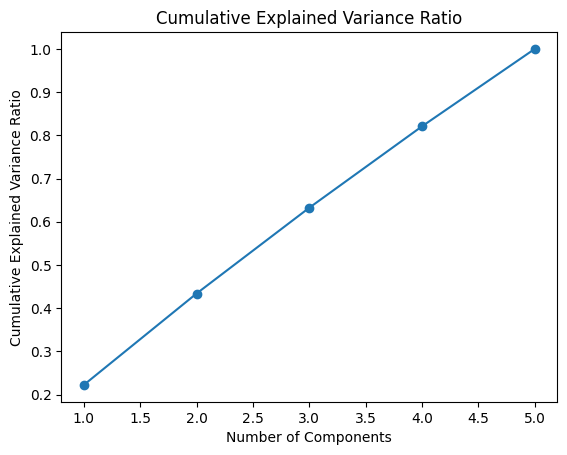

Explained Variance Ratio:
[0.22244938 0.21148036 0.19851167 0.18842897 0.17912961]
Cumulative Explained Variance Ratio:
[0.22244938 0.43392975 0.63244141 0.82087039 1.        ]


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming you have a DataFrame named 'df' containing your data

# Step 1: Data Preparation
# Extract the numeric features from the DataFrame
numeric_features = df.select_dtypes(include=[np.number])

# Step 2: Standardize the dataset
standardized_data = (numeric_features - numeric_features.mean()) / numeric_features.std()

# Step 3: Perform PCA
pca = PCA()
pca.fit(standardized_data)

# Step 4: Determine the optimal number of components
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
n_components = np.argmax(cumulative_variance_ratio >= 0.99) + 1

# Plot the cumulative explained variance ratio
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio')
plt.show()

# Step 5: Perform PCA with the selected number of components
pca = PCA(n_components=n_components)
pca_data = pca.fit_transform(standardized_data)

# Step 6: Interpret the results
# Print the explained variance ratio of each principal component
print("Explained Variance Ratio:")
print(explained_variance_ratio)

# Print the cumulative explained variance ratio
print("Cumulative Explained Variance Ratio:")
print(cumulative_variance_ratio)

# Optionally, you can access the principal components themselves
principal_components = pd.DataFrame(
    data=pca.components_,
    columns=standardized_data.columns,
    index=[f"PC{i+1}" for i in range(n_components)]
)

# The transformed data after PCA can be stored in a DataFrame
pca_df = pd.DataFrame(data=pca_data, columns=[f"PC{i+1}" for i in range(n_components)])


In [21]:
pca_df

,PC1,PC2,PC3,PC4,PC5
0,0.368348,-1.318356,0.020816,0.868969,-1.143343
1,1.272501,2.103935,-0.010257,4.338697,-0.336384
2,1.446994,2.764690,-0.016375,5.007816,-0.180741
3,1.193192,1.799007,-0.005509,4.042715,-0.405638
4,1.246198,2.000154,-0.007552,4.245211,-0.358497
...,...,...,...,...,...
111959,-1.689884,-1.024013,0.431430,0.513764,1.192083
111960,-1.639595,-0.428811,0.256914,-0.008590,1.106236
111961,-0.246450,5.327709,0.002742,4.483603,2.193540
111962,-1.693759,-1.066131,0.443280,0.547400,1.197489


This code splits the data into features and target variable, uses StratifiedKFold to generate training and testing sets, and then checks the distribution of the target variable in each set. Finally, it prints the percentage of non-fraudulent and fraudulent transactions in the dataset.

In [23]:
# Split data into features and target variable
X = pca_df

# Use StratifiedKFold to split data into five folds
sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

# Iterate over each fold and generate training and testing sets
for train_index, test_index in sss.split(X, y):
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# Convert training and testing sets to arrays and check distribution of target variable
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values
train_counts_label = np.unique(original_ytrain, return_counts=True)[1]
test_counts_label = np.unique(original_ytest, return_counts=True)[1]

# Print percentage of non-fraudulent and fraudulent transactions in dataset
print('No Frauds', round(y.value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(y.value_counts()[1]/len(df) * 100,2), '% of the dataset')

# Print distribution of target variable in training and testing sets
print('-' * 100)
print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))


No Frauds 99.22 % of the dataset
Frauds 0.78 % of the dataset
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99222971 0.00777029]
[0.99227403 0.00772597]


Function for plotting confusion matrix

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          ax=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    if ax is None:
        fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)

    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)
    ax.grid(False)


    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')


# **Undersampling**

In [25]:
# Apply undersampling to balance the dataset
undersampler = RandomUnderSampler(random_state=4521)
X_train_und, y_train_und = undersampler.fit_resample(original_Xtrain, original_ytrain)

Logistic Regression

In [26]:
# Create a logistic regression model and fit it on the training data
lr_model = LogisticRegression()
lr_model.fit(X_train_und, y_train_und)

# Predict the target variable on the testing data
y_pred_lr_und = lr_model.predict(original_Xtest)

# Print the classification report to evaluate the model performance
print(classification_report(original_ytest, y_pred_lr_und))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     22219
           1       0.14      0.75      0.23       173

    accuracy                           0.96     22392
   macro avg       0.57      0.86      0.61     22392
weighted avg       0.99      0.96      0.97     22392



Confusion matrix, without normalization
[[21395   824]
 [   43   130]]


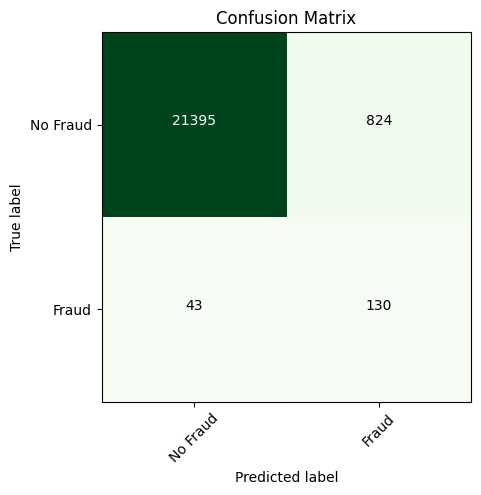

In [27]:
# Create a confusion matrix
cm_und = confusion_matrix(original_ytest, y_pred_lr_und)

labels = ['No Fraud', 'Fraud']

# Plot the confusion matrix
plot_confusion_matrix(cm_und,labels,title="Confusion Matrix",cmap=plt.cm.Greens)

# **Oversampling**

by SMOTE

Synthetic Minority Over-sampling Technique (SMOTE) for oversampling in Python. SMOTE is a popular oversampling technique that generates synthetic samples for the minority class by interpolating between neighboring instances.

In [28]:
# Instantiate the SMOTE oversampler
oversampler = SMOTE(random_state=42)

# Fit and transform the data using the oversampler
X_train_over, y_train_over = oversampler.fit_resample(original_Xtrain, original_ytrain)

Logistic Regression

In [29]:
# Create a logistic regression model and fit it on the training data
lr_model = LogisticRegression()
lr_model.fit(X_train_over, y_train_over)

# Predict the target variable on the testing data
y_pred_lr_over = lr_model.predict(original_Xtest)

# Print the classification report to evaluate the model performance
print(classification_report(original_ytest, y_pred_lr_over))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     22219
           1       0.14      0.75      0.24       173

    accuracy                           0.96     22392
   macro avg       0.57      0.86      0.61     22392
weighted avg       0.99      0.96      0.97     22392



Confusion matrix, without normalization
[[21421   798]
 [   43   130]]


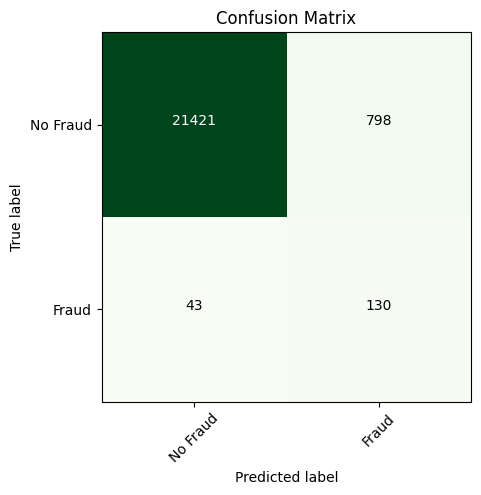

In [30]:
# Create a confusion matrix
cm_over = confusion_matrix(original_ytest, y_pred_lr_over)

labels = ['No Fraud', 'Fraud']
# Plot the confusion matrix
plot_confusion_matrix(cm_over,labels,title="Confusion Matrix",cmap=plt.cm.Greens)

# **Neural Networks**

Undersampling

Epoch 1/10
313/313 [==============================] - 2s 3ms/step - loss: 0.5614 - accuracy: 0.7436 - val_loss: 0.3647 - val_accuracy: 0.7857
Epoch 2/10
313/313 [==============================] - 1s 2ms/step - loss: 0.5223 - accuracy: 0.7796 - val_loss: 0.4091 - val_accuracy: 0.7857
Epoch 3/10
313/313 [==============================] - 1s 3ms/step - loss: 0.5125 - accuracy: 0.7804 - val_loss: 0.4125 - val_accuracy: 0.7786
Epoch 4/10
313/313 [==============================] - 1s 3ms/step - loss: 0.5120 - accuracy: 0.7859 - val_loss: 0.3386 - val_accuracy: 0.8071
Epoch 5/10
313/313 [==============================] - 1s 3ms/step - loss: 0.5005 - accuracy: 0.7835 - val_loss: 0.3881 - val_accuracy: 0.7786
Epoch 6/10
313/313 [==============================] - 1s 3ms/step - loss: 0.5018 - accuracy: 0.7788 - val_loss: 0.3746 - val_accuracy: 0.8071
Epoch 7/10
313/313 [==============================] - 1s 2ms/step - loss: 0.4962 - accuracy: 0.7835 - val_loss: 0.3787 - val_accuracy: 0.7786
Epoch 

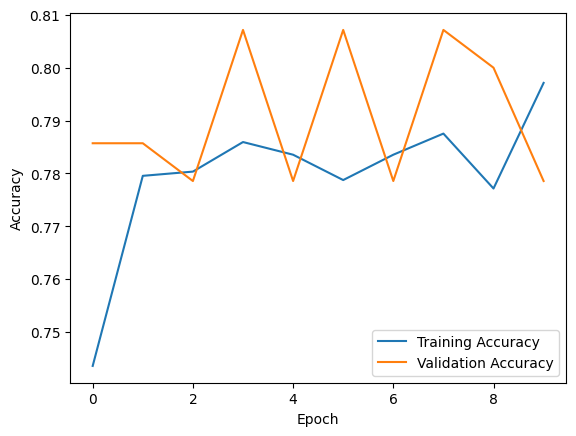

In [31]:
from tensorflow.keras.layers import Dropout

# Define the neural network model with dropout layers
model_und = Sequential()
model_und.add(Dense(64, activation='relu', input_dim=X_train_over.shape[1]))
model_und.add(Dropout(0.2))
model_und.add(Dense(64, activation='relu'))
model_und.add(Dropout(0.2))
model_und.add(Dense(1, activation='sigmoid'))

# Compile the model with binary crossentropy and Adam optimizer
model_und.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with 10 epochs, batch size of 4, and validation split of 0.1
history = model_und.fit(X_train_und, y_train_und, epochs=10, batch_size=4, validation_split=0.1)

# Plot the training and validation accuracy over time
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


700/700 [==============================] - 1s 1ms/step
Confusion matrix, without normalization
[[21560   659]
 [   50   123]]


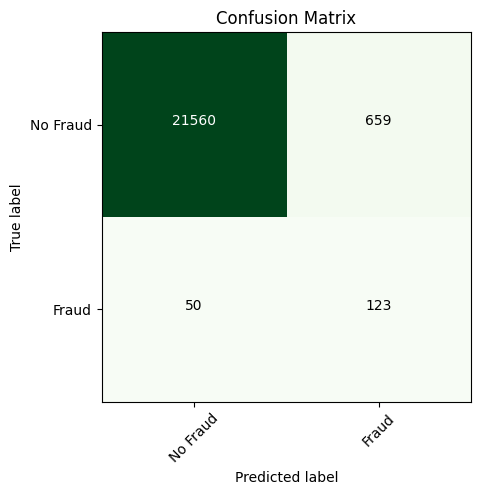

In [32]:
# Predict the labels of the test data using the trained model
y_pred = model_und.predict(original_Xtest)
y_pred_nn_und = (y_pred > 0.5).astype('int')

labels = ['No Fraud', 'Fraud']

# Calculate the confusion matrix
cm_und_nn = confusion_matrix(original_ytest, y_pred_nn_und)

# Plot the confusion matrix
plot_confusion_matrix(cm_und_nn,labels,title="Confusion Matrix",cmap=plt.cm.Greens)

Oversampling

Epoch 1/10
1111/1111 [==============================] - 4s 3ms/step - loss: 0.4273 - accuracy: 0.8296 - val_loss: 0.5251 - val_accuracy: 0.6764
Epoch 2/10
1111/1111 [==============================] - 4s 3ms/step - loss: 0.3503 - accuracy: 0.8495 - val_loss: 0.5281 - val_accuracy: 0.6859
Epoch 3/10
1111/1111 [==============================] - 3s 3ms/step - loss: 0.3195 - accuracy: 0.8605 - val_loss: 0.4392 - val_accuracy: 0.7606
Epoch 4/10
1111/1111 [==============================] - 3s 3ms/step - loss: 0.2986 - accuracy: 0.8703 - val_loss: 0.4493 - val_accuracy: 0.7564
Epoch 5/10
1111/1111 [==============================] - 3s 3ms/step - loss: 0.2827 - accuracy: 0.8769 - val_loss: 0.4687 - val_accuracy: 0.7619
Epoch 6/10
1111/1111 [==============================] - 3s 3ms/step - loss: 0.2696 - accuracy: 0.8834 - val_loss: 0.3641 - val_accuracy: 0.8325
Epoch 7/10
1111/1111 [==============================] - 3s 3ms/step - loss: 0.2578 - accuracy: 0.8907 - val_loss: 0.3646 - val_accuracy:

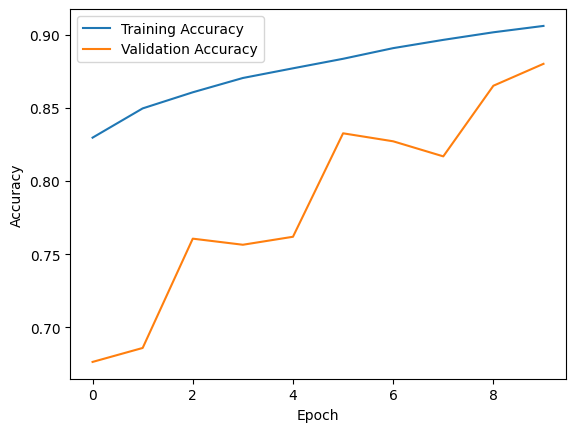

In [33]:
# Define the neural network model
model_over = Sequential()
model_over.add(Dense(64, activation='relu', input_dim=X_train_over.shape[1]))
model_over.add(Dense(32, activation='relu'))
model_over.add(Dense(1, activation='sigmoid'))

# Compile the model
model_over.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model_over.fit(X_train_over, y_train_over, epochs=10, batch_size=128, validation_split=0.2)

# Plot the training and validation accuracy over time
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

700/700 [==============================] - 1s 1ms/step
Confusion matrix, without normalization
[[20869  1350]
 [   54   119]]


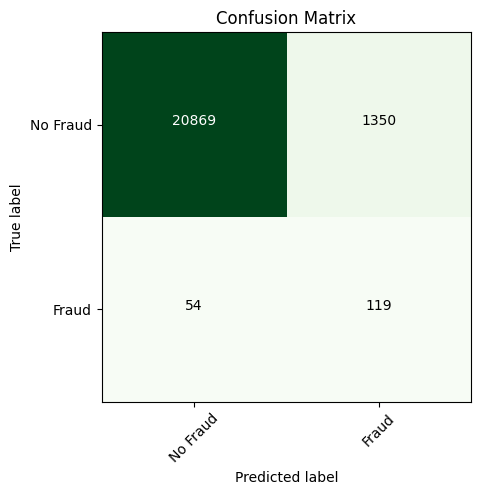

In [34]:
# Predict the labels of the test data using the trained model
y_pred = model_over.predict(original_Xtest)
y_pred_nn_over = (y_pred > 0.5).astype('int')

labels = ['No Fraud', 'Fraud']

# Calculate the confusion matrix
cm_over_nn = confusion_matrix(original_ytest, y_pred_nn_over)

# Plot the confusion matrix
plot_confusion_matrix(cm_over_nn,labels,title="Confusion Matrix",cmap=plt.cm.Greens)

Comparison of All

Confusion matrix, without normalization
[[21395   824]
 [   43   130]]
Confusion matrix, without normalization
[[21560   659]
 [   50   123]]
Confusion matrix, without normalization
[[21421   798]
 [   43   130]]
Confusion matrix, without normalization
[[20869  1350]
 [   54   119]]


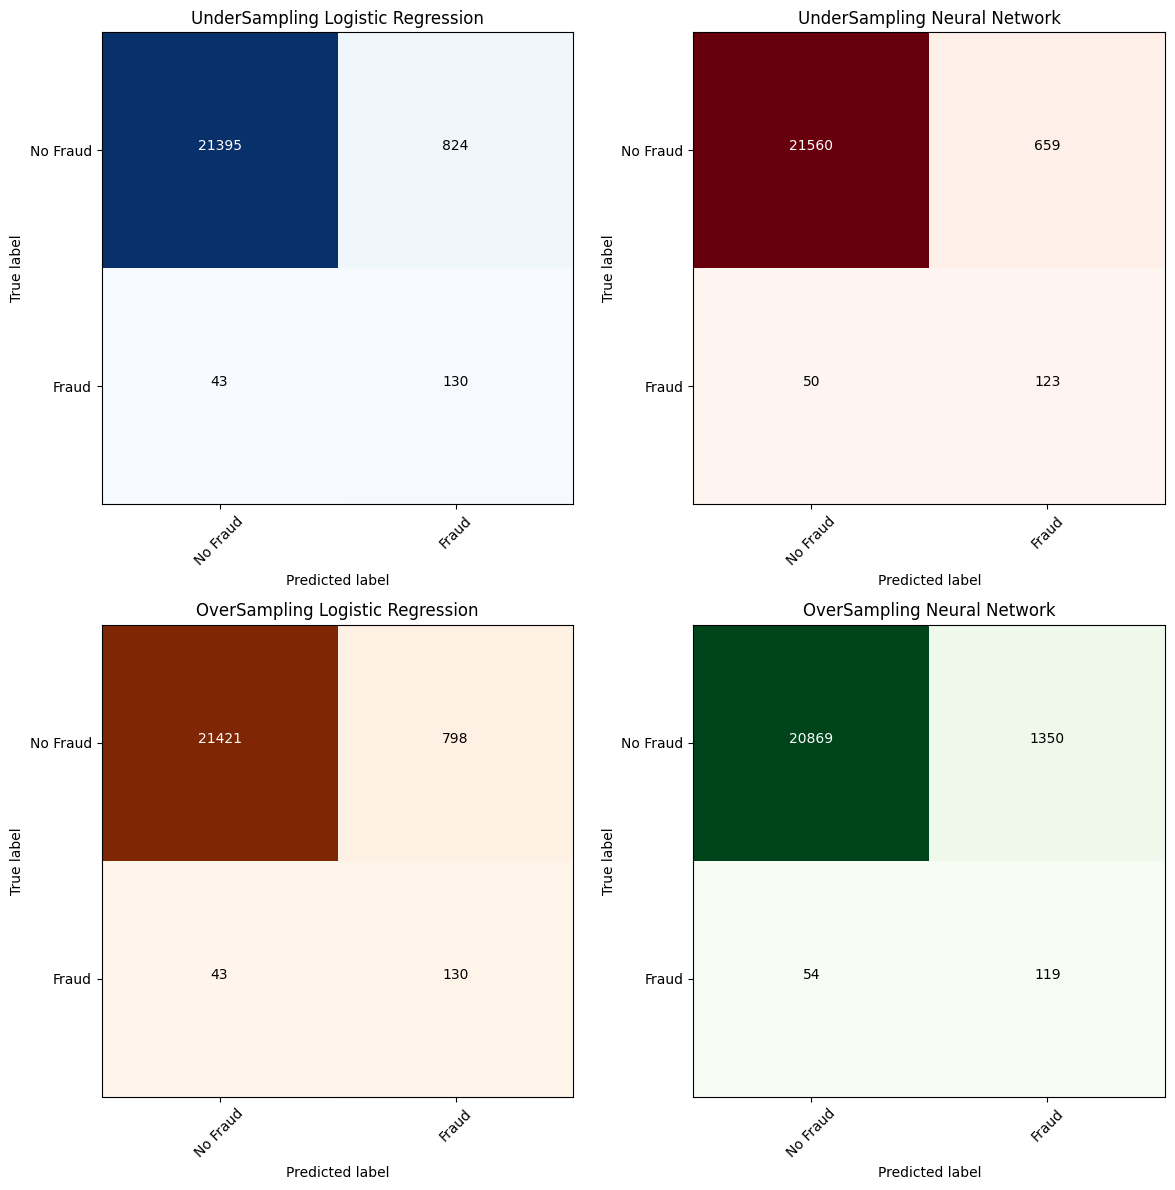

In [35]:
# Initialize the figure
fig = plt.figure(figsize=(12, 12))

# Create the subplots
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

# Plot Undersampling LR
plot_confusion_matrix(cm_und, labels, title="UnderSampling Logistic Regression", cmap=plt.cm.Blues, ax=ax1)

# Plot Undersampling NN
plot_confusion_matrix(cm_und_nn, labels, title="UnderSampling Neural Network", cmap=plt.cm.Reds, ax=ax2)

# Plot Oversampling LR
plot_confusion_matrix(cm_over, labels, title="OverSampling Logistic Regression", cmap=plt.cm.Oranges, ax=ax3)

# Plot Oversampling NN
plot_confusion_matrix(cm_over_nn, labels, title="OverSampling Neural Network", cmap=plt.cm.Greens, ax=ax4)

plt.tight_layout()
plt.show()


CBA and MCC

In [36]:
from sklearn.metrics import matthews_corrcoef, confusion_matrix

# Calculate the confusion matrix and MCC for each set of predicted labels
cm_1 = cm_und
cm_2 = cm_und_nn
cm_3 = cm_over
cm_4 = cm_over_nn

mcc_1 = matthews_corrcoef(original_ytest, y_pred_lr_und)
mcc_2 = matthews_corrcoef(original_ytest, y_pred_nn_und)
mcc_3 = matthews_corrcoef(original_ytest, y_pred_lr_over)
mcc_4 = matthews_corrcoef(original_ytest, y_pred_nn_over)

# Calculate the CBA for each set of predicted labels
cba_1 = (cm_1[0][0] / (cm_1[0][0] + cm_1[0][1])) * (cm_1[1][1] / (cm_1[1][0] + cm_1[1][1]))
cba_2 = (cm_2[0][0] / (cm_2[0][0] + cm_2[0][1])) * (cm_2[1][1] / (cm_2[1][0] + cm_2[1][1]))
cba_3 = (cm_3[0][0] / (cm_3[0][0] + cm_3[0][1])) * (cm_3[1][1] / (cm_3[1][0] + cm_3[1][1]))
cba_4 = (cm_4[0][0] / (cm_4[0][0] + cm_4[0][1])) * (cm_4[1][1] / (cm_4[1][0] + cm_4[1][1]))

# Print the CBA and MCC values for each set of predicted labels
print("Set 1 - CBA: {:.4f}, MCC: {:.4f}".format(cba_1, mcc_1))
print("Set 2 - CBA: {:.4f}, MCC: {:.4f}".format(cba_2, mcc_2))
print("Set 3 - CBA: {:.4f}, MCC: {:.4f}".format(cba_3, mcc_3))
print("Set 4 - CBA: {:.4f}, MCC: {:.4f}".format(cba_4, mcc_4))

Set 1 - CBA: 0.7236, MCC: 0.3097
Set 2 - CBA: 0.6899, MCC: 0.3249
Set 3 - CBA: 0.7245, MCC: 0.3143
Set 4 - CBA: 0.6461, MCC: 0.2218


In [37]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# Calculate the F1 score for each set of predicted labels
f1_1 = f1_score(original_ytest, y_pred_lr_und)
f1_2 = f1_score(original_ytest, y_pred_nn_und)
f1_3 = f1_score(original_ytest, y_pred_lr_over)
f1_4 = f1_score(original_ytest, y_pred_nn_over)

# Calculate the accuracy score for each set of predicted labels
acc_1 = accuracy_score(original_ytest, y_pred_lr_und)
acc_2 = accuracy_score(original_ytest, y_pred_nn_und)
acc_3 = accuracy_score(original_ytest, y_pred_lr_over)
acc_4 = accuracy_score(original_ytest, y_pred_nn_over)

# Print the CBA, MCC, F1 score, and accuracy values for each set of predicted labels
print("Set 1 - CBA: {:.4f}, MCC: {:.4f}, F1 score: {:.4f}, Accuracy: {:.4f}".format(cba_1, mcc_1, f1_1, acc_1))
print("Set 2 - CBA: {:.4f}, MCC: {:.4f}, F1 score: {:.4f}, Accuracy: {:.4f}".format(cba_2, mcc_2, f1_2, acc_2))
print("Set 3 - CBA: {:.4f}, MCC: {:.4f}, F1 score: {:.4f}, Accuracy: {:.4f}".format(cba_3, mcc_3, f1_3, acc_3))
print("Set 4 - CBA: {:.4f}, MCC: {:.4f}, F1 score: {:.4f}, Accuracy: {:.4f}".format(cba_4, mcc_4, f1_4, acc_4))



Set 1 - CBA: 0.7236, MCC: 0.3097, F1 score: 0.2307, Accuracy: 0.9613
Set 2 - CBA: 0.6899, MCC: 0.3249, F1 score: 0.2576, Accuracy: 0.9683
Set 3 - CBA: 0.7245, MCC: 0.3143, F1 score: 0.2361, Accuracy: 0.9624
Set 4 - CBA: 0.6461, MCC: 0.2218, F1 score: 0.1449, Accuracy: 0.9373


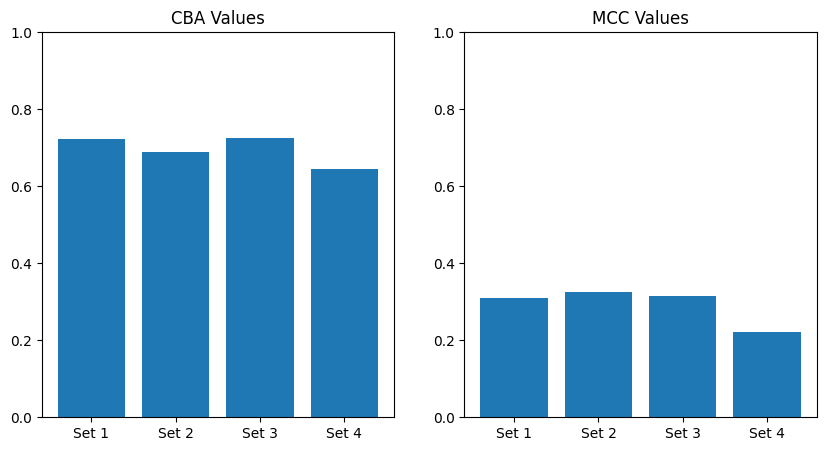

In [38]:
# Plot the CBA and MCC values for each set of predicted
# Define the CBA and MCC values
cba_values = [cba_1, cba_2, cba_3, cba_4]
mcc_values = [mcc_1, mcc_2, mcc_3, mcc_4]

# Define the x-axis labels
x_labels = ["Set 1", "Set 2", "Set 3", "Set 4"]

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the CBA values
ax1.bar(x_labels, cba_values)
ax1.set_title("CBA Values")
ax1.set_ylim(0, 1)

# Plot the MCC values
ax2.bar(x_labels, mcc_values)
ax2.set_title("MCC Values")
ax2.set_ylim(0, 1)

# Show the plot
plt.show()


The CBA metric is defined as the product of the precision and recall, both of which are ratios between the correctly classified instances and the total instances. The precision measures the accuracy of the positive predictions made by the classifier, while the recall measures the completeness of the positive predictions.

The CBA metric is a good way to evaluate the overall performance of a binary classifier because it takes into account both the accuracy and completeness of the predictions.

MCC stands for Matthews Correlation Coefficient and is a metric used to evaluate the performance of binary classifiers. It takes into account all four values in the confusion matrix, i.e., true positives, true negatives, false positives, and false negatives.

The MCC metric is defined as the covariance between the predicted binary labels and the true binary labels, divided by the product of their standard deviations. It ranges from -1 to 1, where a score of 1 indicates perfect classification, 0 indicates a random classification, and -1 indicates perfect inverse classification.

MCC is a useful metric because it is not affected by imbalanced class distributions, unlike some other metrics such as accuracy or precision. It is also useful when the classes are not equally important, as it considers all four values in the confusion matrix.

So MCC will be the main criteria for comparing algorithms

# **XGBoost**

In [39]:
# Compute the ratio of negative to positive examples
neg_pos_ratio = len(original_ytrain[original_ytrain==0]) / len(original_ytrain[original_ytrain==1])

# Create the XGBClassifier with scale_pos_weight
xgb_clf = xgb.XGBClassifier(n_estimators=500, learning_rate=0.01, max_depth=5, scale_pos_weight=neg_pos_ratio, random_state=42)

# Fit the model to the training data
xgb_clf.fit(original_Xtrain, original_ytrain)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

Confusion matrix, without normalization
[[21661   558]
 [   55   118]]


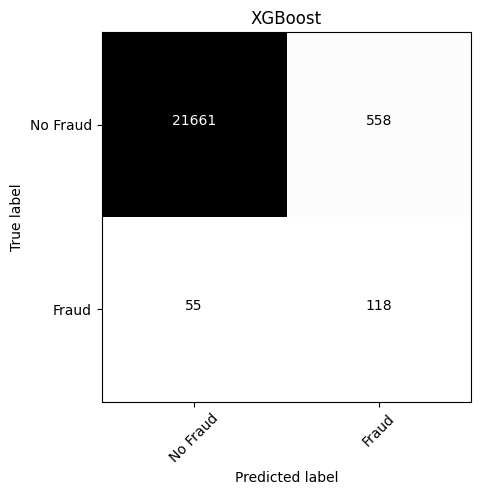

In [40]:
# Predict the labels of the test data using the trained model
y_pred = xgb_clf.predict(original_Xtest)
y_pred_xgb = (y_pred > 0.5).astype('int')

labels = ['No Fraud', 'Fraud']

# Calculate the confusion matrix
cm_xgb = confusion_matrix(original_ytest, y_pred_xgb)

# Plot the confusion matrix
plot_confusion_matrix(cm_xgb,labels,title="XGBoost",cmap=plt.cm.Greys)

In [41]:
mcc = matthews_corrcoef(original_ytest, y_pred_xgb)
mcc

0.33617528679087355

In [42]:
cba = (cm_1[0][0] / (cm_xgb[0][0] + cm_xgb[0][1])) * (cm_xgb[1][1] / (cm_xgb[1][0] + cm_xgb[1][1]))
cba

0.656785696353717

In [43]:
f1 = f1_score(original_ytest, y_pred_xgb)
acc = accuracy_score(original_ytest, y_pred_xgb)
print(f1)
print(acc)

0.2779740871613663
0.9726241514826723


# **Random Forest**

In [44]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=36)
rf.fit(X_train_over,y_train_over)
predicted=rf.predict(original_Xtest)
print('Classification report:\n', classification_report(original_ytest, predicted))
conf_mat = confusion_matrix(y_true=original_ytest, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)
print('Share of Non-Fraud in Test Data:', 1-round(original_ytest.sum()/len(original_ytest),4))

Classification report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99     22219
           1       0.13      0.36      0.19       173

    accuracy                           0.98     22392
   macro avg       0.56      0.67      0.59     22392
weighted avg       0.99      0.98      0.98     22392

Confusion matrix:
 [[21783   436]
 [  110    63]]
Share of Non-Fraud in Test Data: 0.9923


Confusion matrix, without normalization
[[21783   436]
 [  110    63]]


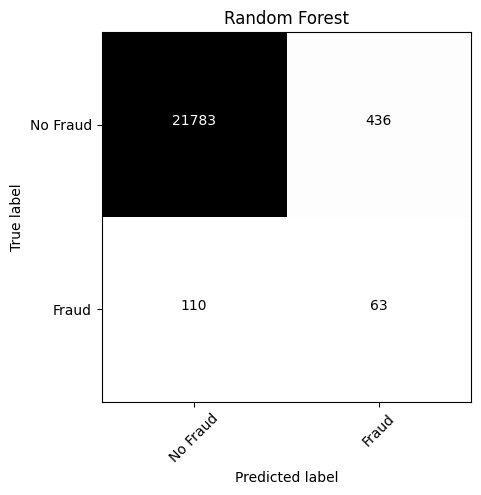

In [45]:
# Predict the labels of the test data using the trained model
predicted
y_pred_rf = (predicted > 0.5).astype('int')

labels = ['No Fraud', 'Fraud']

# Calculate the confusion matrix
cm_rf = confusion_matrix(original_ytest, y_pred_rf)

# Plot the confusion matrix
plot_confusion_matrix(cm_rf,labels,title="Random Forest",cmap=plt.cm.Greys)

In [47]:
from sklearn.metrics import matthews_corrcoef, confusion_matrix
mcc = matthews_corrcoef(original_ytest, y_pred_rf)
mcc

0.20437171488581934

In [46]:
cba = (cm_rf[0][0] / (cm_rf[0][0] + cm_rf[0][1])) * (cm_rf[1][1] / (cm_rf[1][0] + cm_rf[1][1]))
cba

0.35701595806536457

In [48]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

f1 = f1_score(original_ytest, y_pred_rf)
acc = accuracy_score(original_ytest, y_pred_rf)
print(f1)
print(acc)

0.18749999999999997
0.9756162915326902
